In [47]:
import numpy as np
from simulate_noise import simulate_noise
myarray = np.load('PSD.npz')
#arr_0 = ASDs #arr_1 = PSDs #arr_2 = total events #arr_3 = noskips #arr_4=rcorr #arr_5=FFTs
PSDs = myarray['arr_1']
Single_PSD = PSDs[0][0][90]

waveform, f, time = simulate_noise.getNoiseWaveform(Single_PSD)

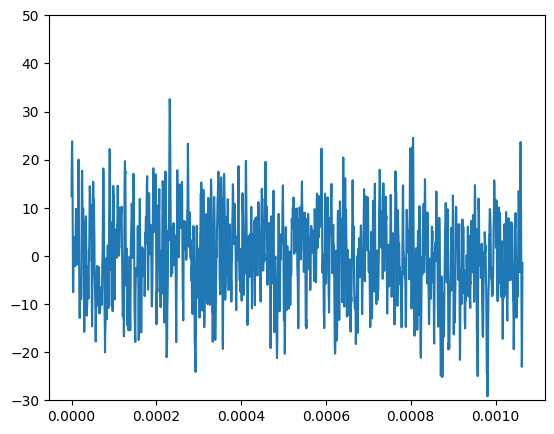

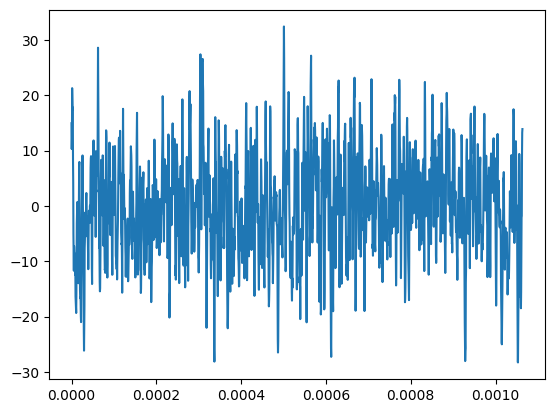

In [48]:
import matplotlib.pyplot as plt
plt.figure(1).set_figheight(5)
plt.plot(time,waveform)
plt.ylim(-30,50)

plt.figure(2)
plt.plot(time,f)

/tmp/ipykernel_99002/772141478.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.semilogy(freq,New_PSD / Single_PSD)


Text(0, 0.5, 'PSD [Hz]^-1')

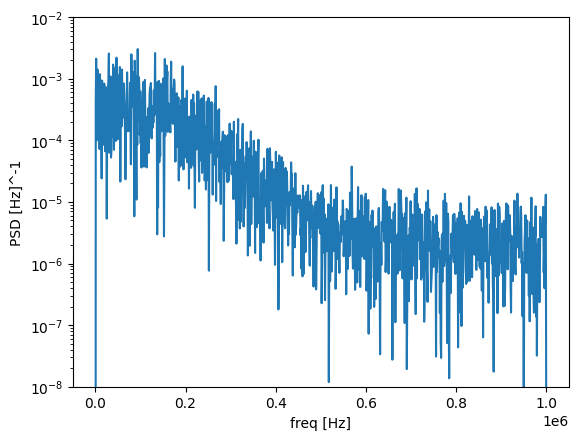

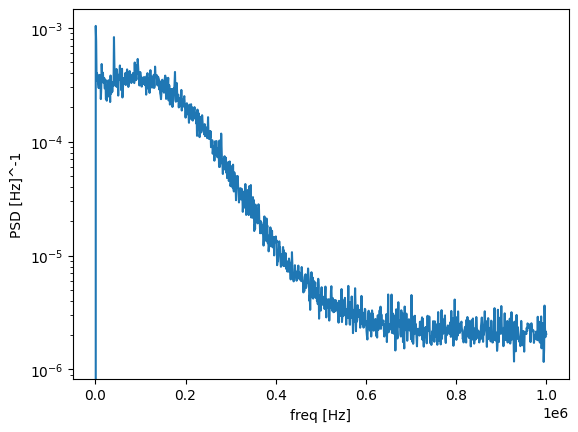

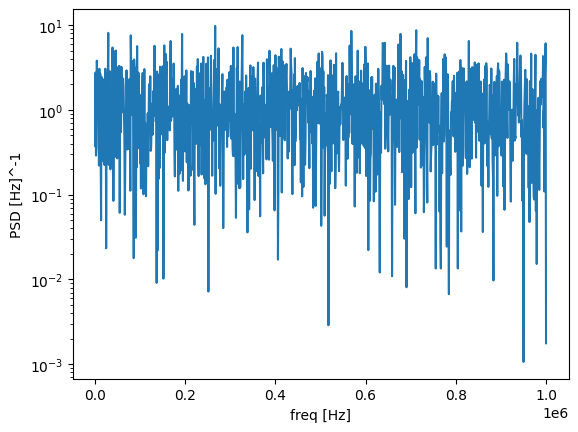

In [18]:
N = 2128
SampleSpacing = 0.5*10**(-6)
T = SampleSpacing * N

freq = np.fft.rfftfreq(N,SampleSpacing)
New_PSD = (2*T/N**2)*np.abs(np.fft.rfft(waveform))**2

plt.figure(3)
plt.semilogy(freq,New_PSD)
plt.xlabel("freq [Hz]")
plt.ylabel("PSD [Hz]^-1")
plt.ylim(10e-9,10e-3)

plt.figure(4)
plt.semilogy(freq,Single_PSD)
plt.xlabel("freq [Hz]")
plt.ylabel("PSD [Hz]^-1")

plt.figure(5)
plt.semilogy(freq,New_PSD / Single_PSD)
plt.xlabel("freq [Hz]")
plt.ylabel("PSD [Hz]^-1")


/home/matt/Documents/ICEBERG/ICEBERG_Noise_Modeling/ICEBERG_Noise_Modeling-poshung-multiple-runs/src/myprocessor.py:291: RuntimeWarning: divide by zero encountered in log
  ax2[tpc][plane].pcolormesh(freq,range(maxwires),np.log(AvgASD[tpc][plane]),cmap = cmap,shading='gouraud', vmin=np.log(.0001),vmax=np.log(.1))


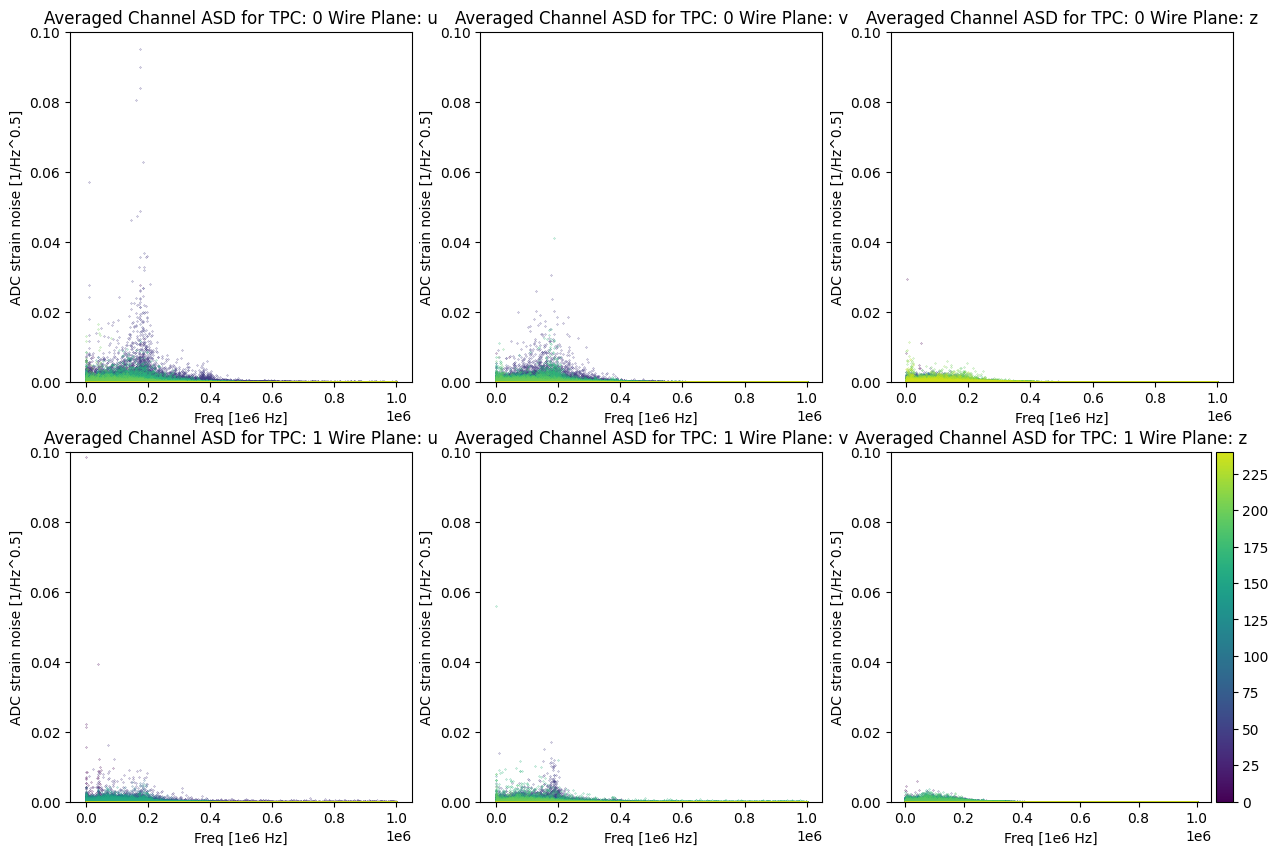

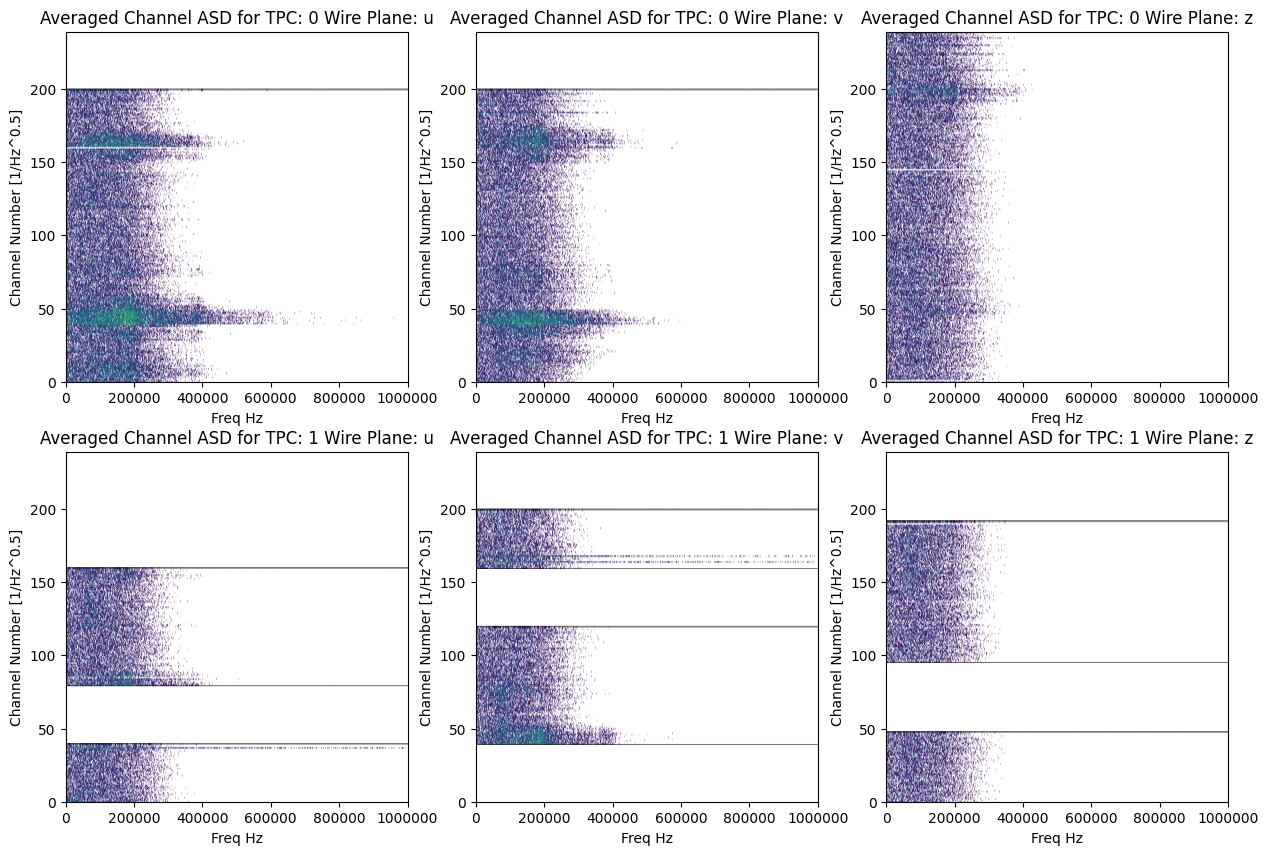

In [4]:
import numpy as np
from simulate_noise import simulate_noise
from myprocessor import myprocessor as myp
import matplotlib.pyplot as plt

myarray = np.load('PSD.npz')
#arr_0 = ASDs #arr_1 = PSDs #arr_2 = total events #arr_3 = noskips #arr_4=rcorr #arr_5=FFTs
PSDs = myarray['arr_1']

#waveforms, fs, times = np.fromiter((simulate_noise.getNoiseWaveform(xi) for xi in PSDs[iTPC][iPlane]), PSDs[iTPC][iPlane].dtype)
numtpcs = 2
numplanes = 3
maxwires = 240
PSDlength = len(PSDs[0][0][0]) #should be rectangular and = 1065
time_indices = 2128
N = time_indices
SampleSpacing = 0.5*10**(-6)
T = SampleSpacing * N

New_Waveform = np.zeros((numtpcs,numplanes,maxwires,time_indices),dtype=float)
New_PSD = np.zeros((numtpcs,numplanes,maxwires,PSDlength),dtype=float)

for iTPC in range(numtpcs):
    for iPlane in range(numplanes):
        #I would like to figure out how to make this step faster!!!
        for iChannel in range(maxwires):
            if(len(PSDs[iTPC][iPlane][iChannel]) != 0):
                New_Waveform[iTPC][iPlane][iChannel], f, time = simulate_noise.getNoiseWaveform(PSDs[iTPC][iPlane][iChannel])
                
                ADCASD, ADCPSD, ADCFFT = myp.get_single_ASDPSDFFT(New_Waveform[iTPC][iPlane][iChannel], SampleSpacing)
                
                New_PSD[iTPC][iPlane][iChannel] = ADCPSD

plt.figure()
myp.HistAvgASDbyPlane(New_PSD, numtpcs, numplanes, maxwires, N, SampleSpacing)

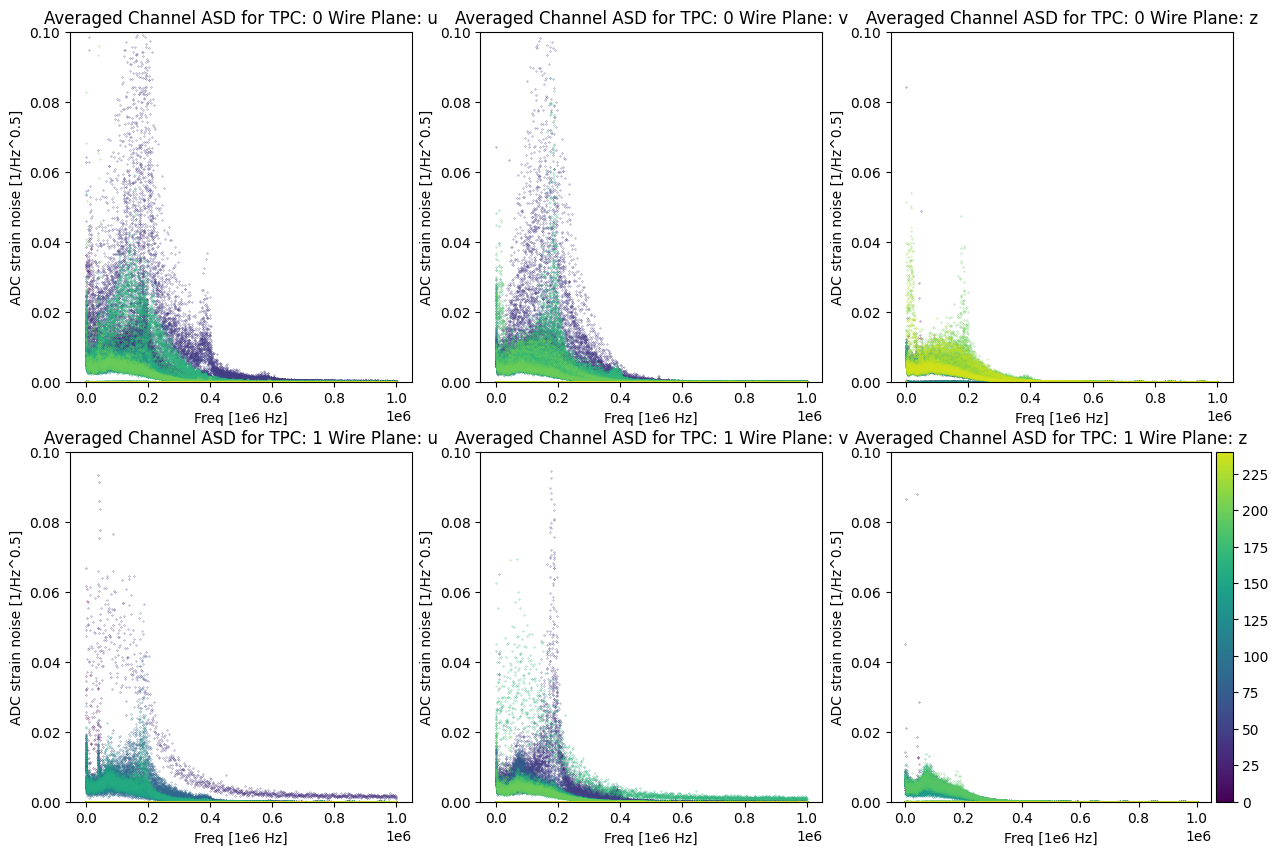

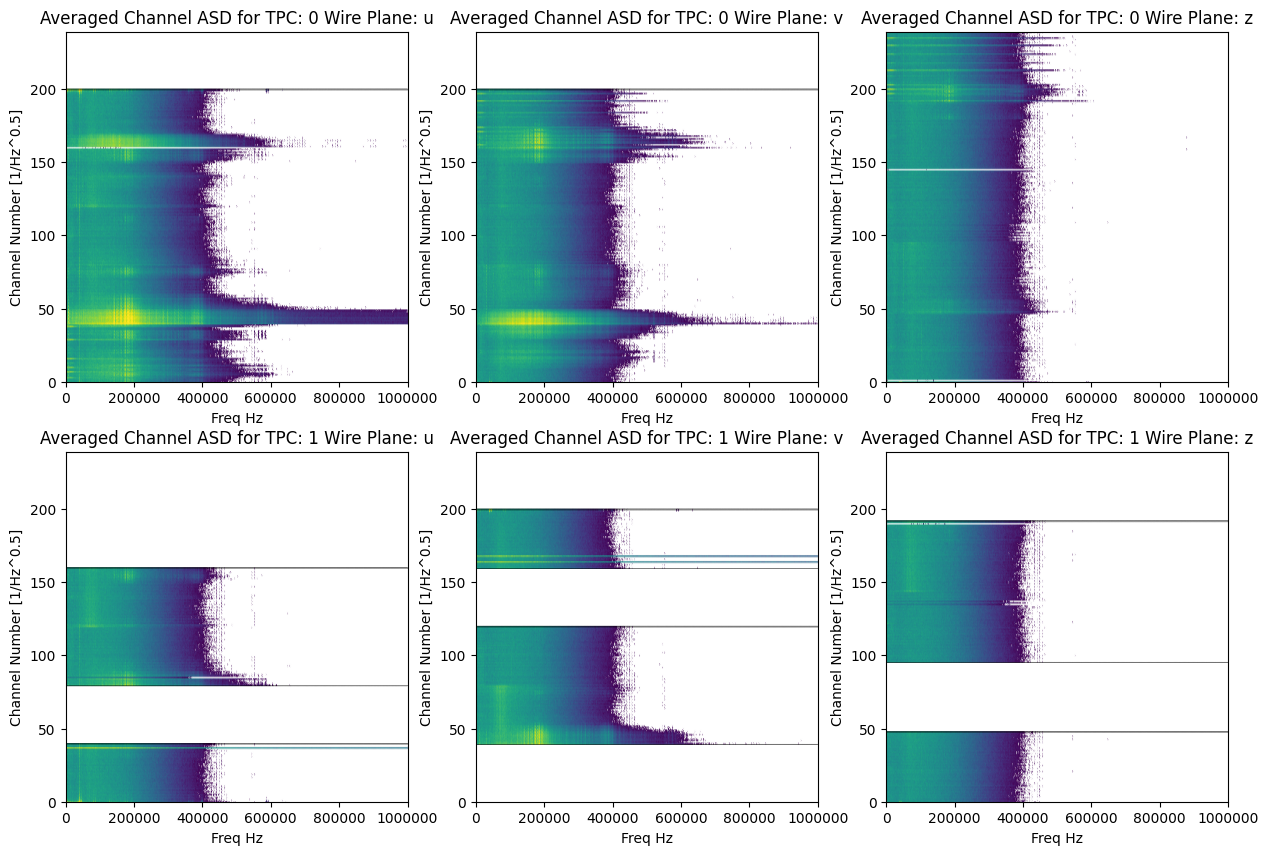

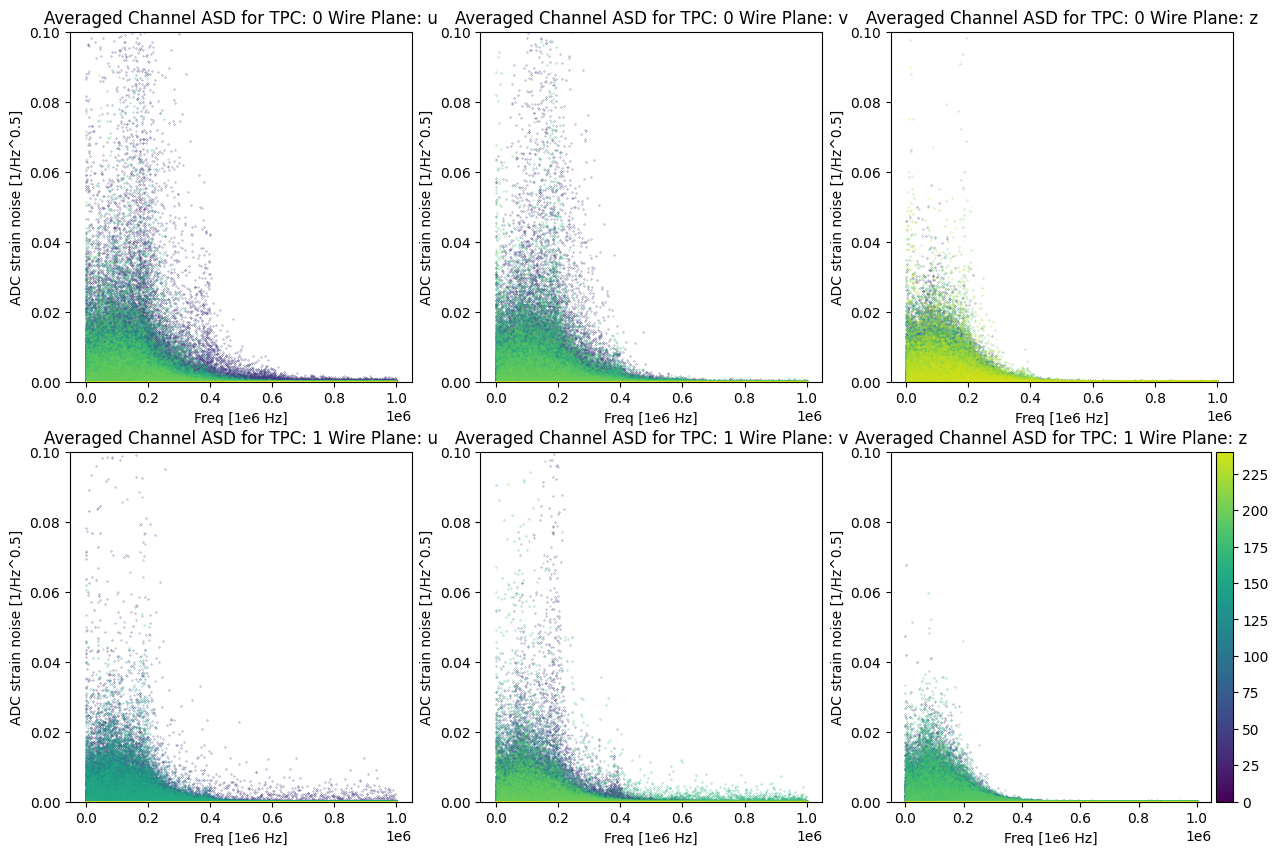

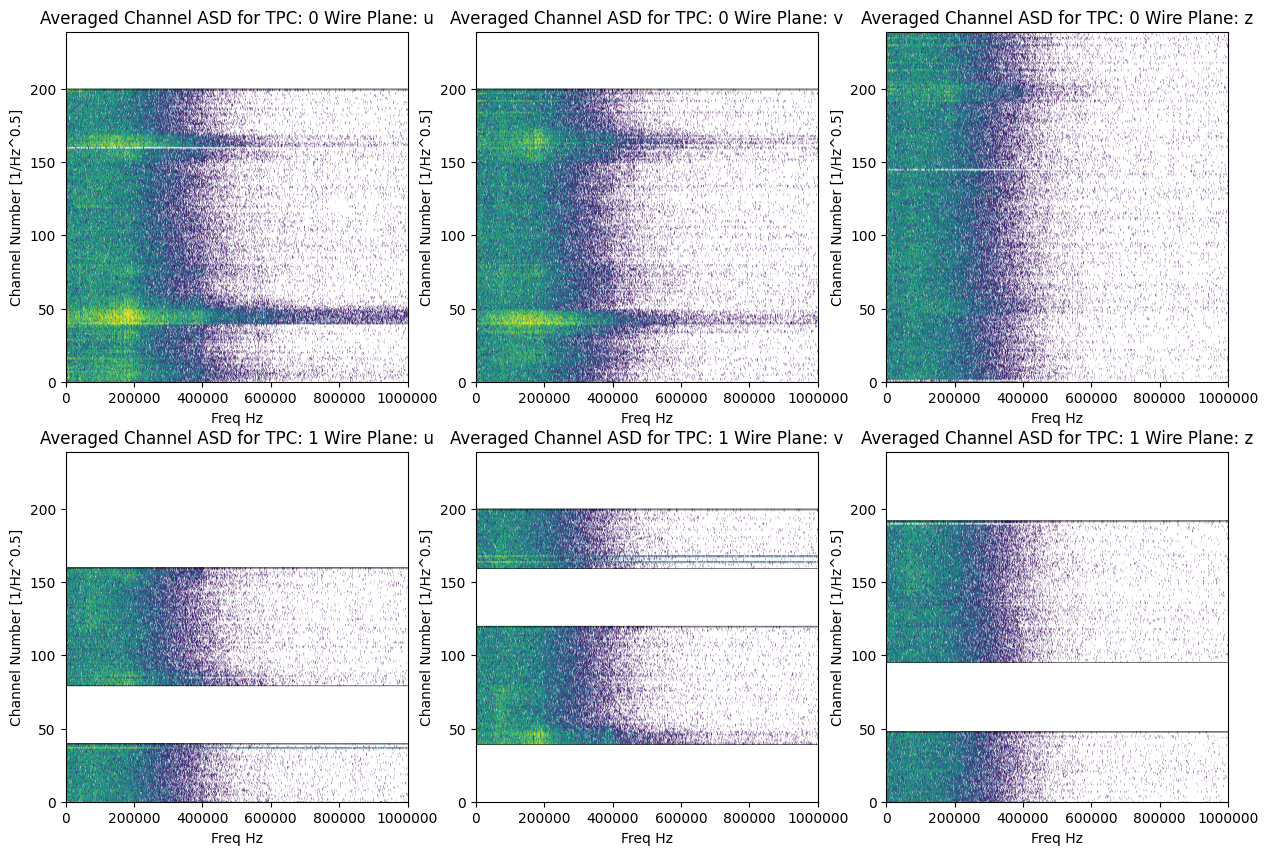

In [6]:
myp.HistAvgASDbyPlane(PSDs*15, numtpcs, numplanes, maxwires, N, SampleSpacing)
myp.HistAvgASDbyPlane(New_PSD*15, numtpcs, numplanes, maxwires, N, SampleSpacing)

In [5]:
l = 5*10**(-2)
time_indices = 2128
Amplitude_Variance = 2/(l*time_indices**2)
print(Amplitude_Variance)
print(np.sqrt(Amplitude_Variance))

8.833173158460059e-06
0.002972065470083063


/tmp/ipykernel_99002/104929599.py:11: RuntimeWarning: invalid value encountered in divide
  Ratio = New_PSD/PSDs
/tmp/ipykernel_99002/104929599.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


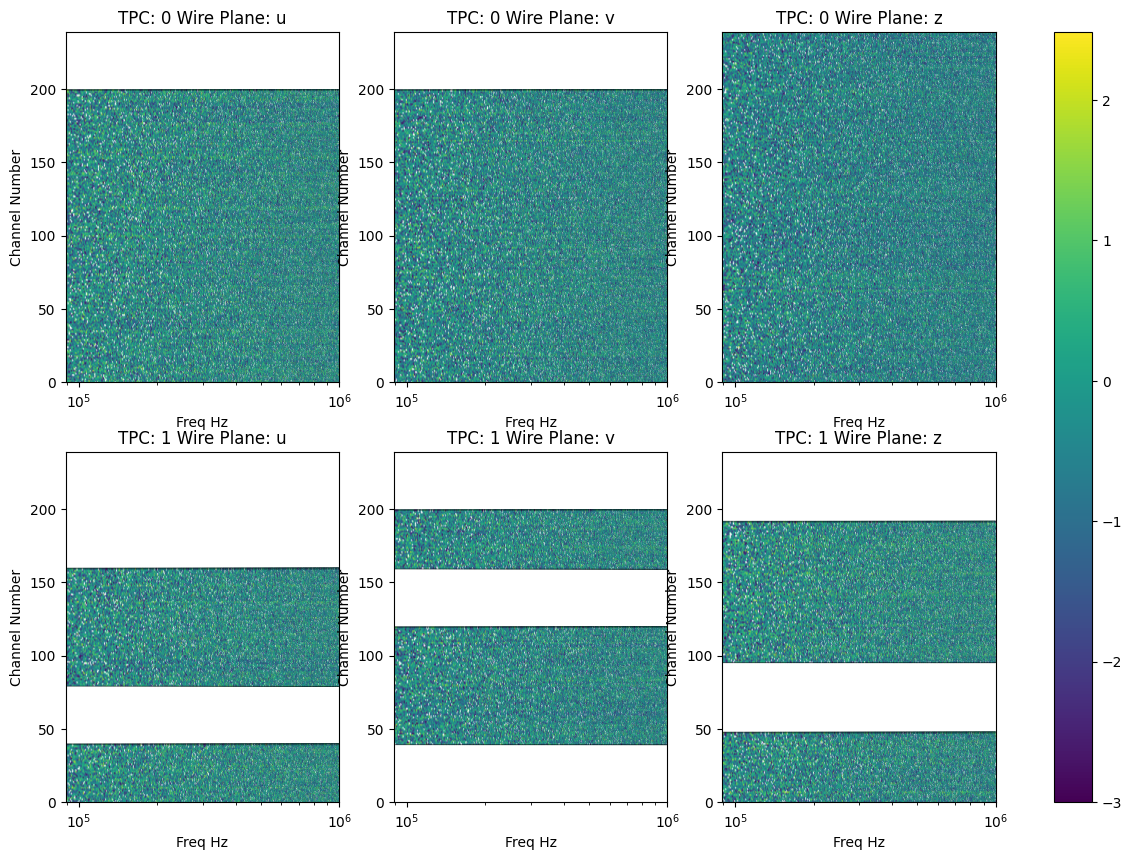

In [12]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable 

#For plot of freq v. channel # v. color
fig2,ax2 = plt.subplots(numtpcs,numplanes,num=2)
fig2.set_figheight(numtpcs*5)
fig2.set_figwidth(numplanes*5)

planenames = ["u", "v", "z"]

Ratio = New_PSD/PSDs

for tpc in range(len(Ratio)):
    for plane in range(len(Ratio[tpc])):
        freq = np.fft.rfftfreq(N,SampleSpacing)
        #The 2d histogram takes only 1d arrays
        #so we have to flatten out our AvgASD array into one long array
        #also we have to do the same for the frequencies
        longRatio = np.empty(0,dtype=float)
        longFreq = np.empty(0,dtype=float)
        for channel in range(len(Ratio[tpc][plane])):
            longRatio = np.concatenate((longRatio, abs(Ratio[tpc][plane][channel])))
            longFreq = np.concatenate((longFreq, freq))
        
        #For 2D plot
        cmap = mpl.cm.get_cmap('viridis')
        cmap.set_under('white')
        im = ax2[tpc][plane].pcolormesh(freq,range(maxwires),np.log(Ratio[tpc][plane]),cmap = cmap,shading='gouraud', vmin = -3)

        ax2[tpc][plane].set_xscale("log")
        ax2[tpc][plane].set_xlabel("Freq Hz")
        ax2[tpc][plane].set_ylabel("Channel Number")
        ax2[tpc][plane].set_title("TPC: " + str(tpc) + " Wire Plane: " + planenames[plane])
fig2.colorbar(im, ax=ax2.ravel().tolist())
plt.show()

[1.64538258 0.03162917 0.66320379 ... 0.39974819 0.11370384 0.01163782]
Mean -0.5411272495743858; STD: 1.2920262583354076
0.5820917197621015
1.046510493556691


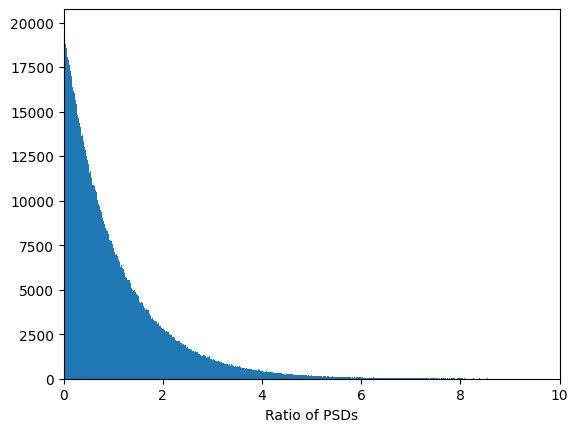

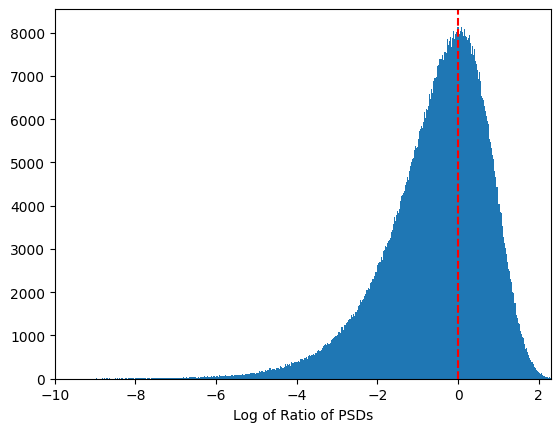

In [42]:
#Let's look at a histogram of these ratio plots
FlatRatios = Ratio.flatten()[~(np.isnan(Ratio.flatten()))]
print(FlatRatios)

plt.figure(1)
plt.hist(FlatRatios, bins = 1000)
plt.xlabel("Ratio of PSDs")
plt.xlim(0,10)

plt.figure(2)
plt.hist(np.log(FlatRatios), bins = 1000)
plt.xlabel("Log of Ratio of PSDs")
plt.axvline(0,color="red",linestyle="--")
plt.xlim(-10,2.7)

print("Mean "+str(np.mean(np.log(FlatRatios)))+"; STD: "+str(np.std(np.log(FlatRatios))))
print(np.exp(np.mean(np.log(FlatRatios))))
print(np.mean(FlatRatios))


TPC: 0 Plane u avg ratio: 1.0462653388536314 avg std: 1.034376021071082 z-score 0.04472777588726802
TPC: 0 Plane v avg ratio: 1.0717672207456181 avg std: 1.057919491098709 z-score 0.06783807402119403
TPC: 0 Plane z avg ratio: 1.04568794481034 avg std: 1.0319317855175212 z-score 0.044274190844336835
TPC: 1 Plane u avg ratio: 1.0507884071551061 avg std: 1.0397931391569761 z-score 0.048844722322637556
TPC: 1 Plane v avg ratio: 1.0504455119025315 avg std: 1.033088768240969 z-score 0.04882979416030693
TPC: 1 Plane z avg ratio: 1.020869239010518 avg std: 1.009232998734597 z-score 0.020678316143729423


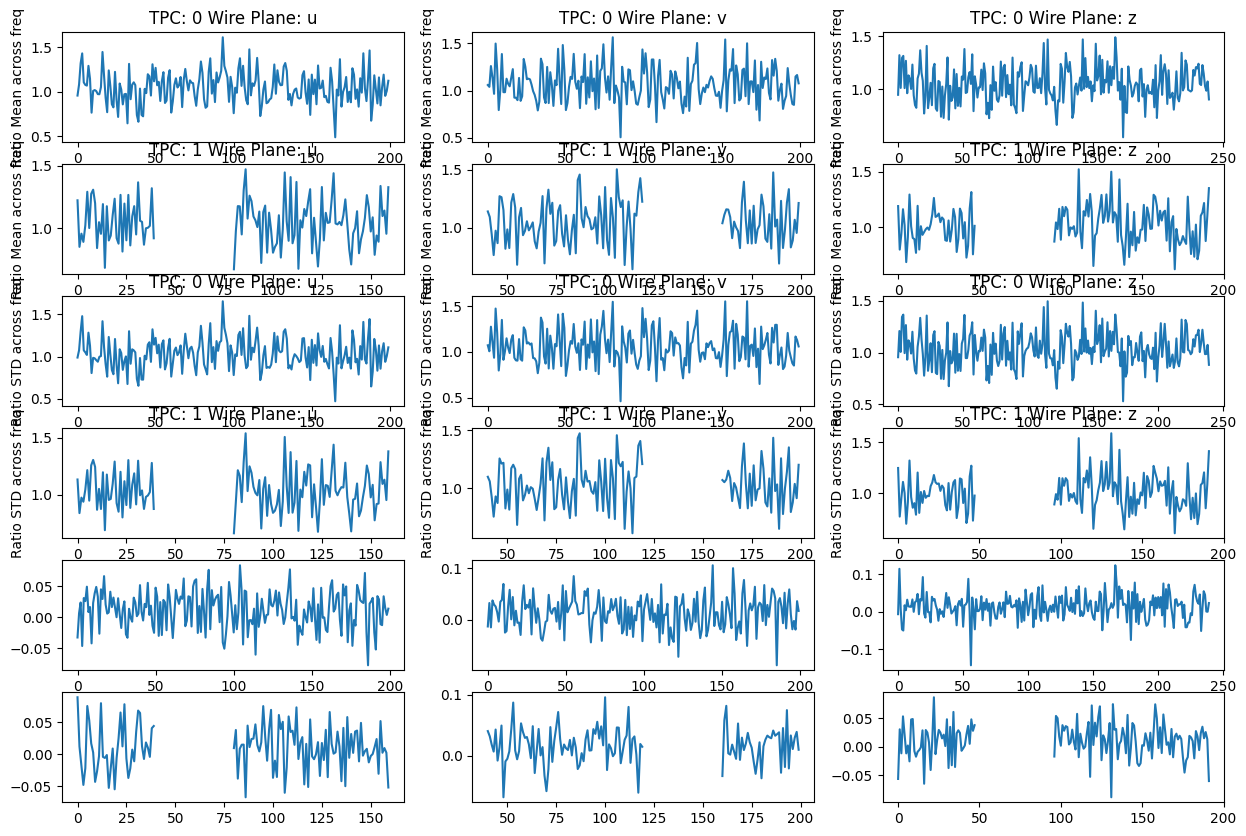

In [8]:
fig,ax = plt.subplots(numtpcs*3,numplanes,num=2)
fig.set_figheight(numtpcs*5)
fig.set_figwidth(numplanes*5)

for tpc in range(len(Ratio)):
    for plane in range(len(Ratio[tpc])):
            means = []
            stds = []
            means_incl_nan = []
            stds_incl_nan = []
            for channel in range(len(Ratio[tpc][plane])):
                means_incl_nan.append(np.average(Ratio[tpc][plane][channel][1:]))
                stds_incl_nan.append(np.std(Ratio[tpc][plane][channel][1:]))
                if np.isnan(Ratio[tpc][plane][channel][50]): continue
                means.append(np.average(Ratio[tpc][plane][channel][1:]))
                stds.append(np.std(Ratio[tpc][plane][channel][1:]))

            ax[tpc][plane].plot(range(len(Ratio[tpc][plane])),means_incl_nan)
            ax[tpc+numtpcs][plane].plot(range(len(Ratio[tpc][plane])),stds_incl_nan)
            ax[tpc+numtpcs*2][plane].plot(range(len(Ratio[tpc][plane])),np.array(means_incl_nan) - np.array(stds_incl_nan))

            ax[tpc][plane].set_xlabel("Channel Number")
            ax[tpc][plane].set_ylabel("Ratio Mean across freq")
            ax[tpc][plane].set_title("TPC: " + str(tpc) + " Wire Plane: " + planenames[plane])

            ax[tpc+numtpcs][plane].set_xlabel("Channel Number")
            ax[tpc+numtpcs][plane].set_ylabel("Ratio STD across freq")
            ax[tpc+numtpcs][plane].set_title("TPC: " + str(tpc) + " Wire Plane: " + planenames[plane])

            mean = np.mean(np.array(means))
            std = np.mean(np.array(stds))
            print("TPC: "+str(tpc)+" Plane "+planenames[plane]+" avg ratio: "+str(mean) + " avg std: "+str(std) + " z-score "+str((mean - 1)/std))

plt.show()

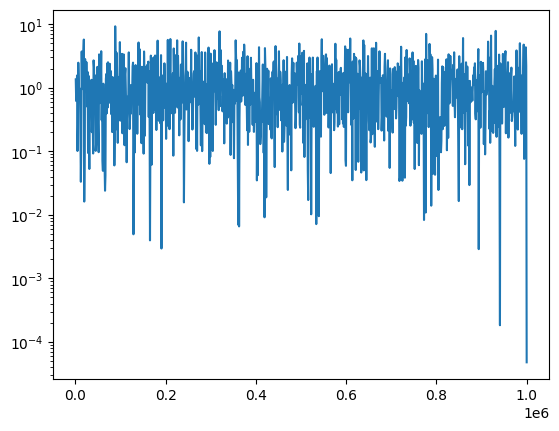

In [9]:
plt.figure()
plt.semilogy(freq,Ratio[0][0][130])